### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [2]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 367.3+ MB


Locate and correct the spikes

In [6]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if we has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

Carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [7]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

lam = 10 ** 3
p = 0.05
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Remove the noise from the spectra using Savitzky–Golay-filtering

In [8]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order))

Scale the absorbances of each spectra by the max value.

In [9]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

Try Min Max Scaling

## 1 Sample Example

In [10]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Despiked_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [11]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])
despiked_peaks, _ = find_peaks(x=sample['Despiked_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'])

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

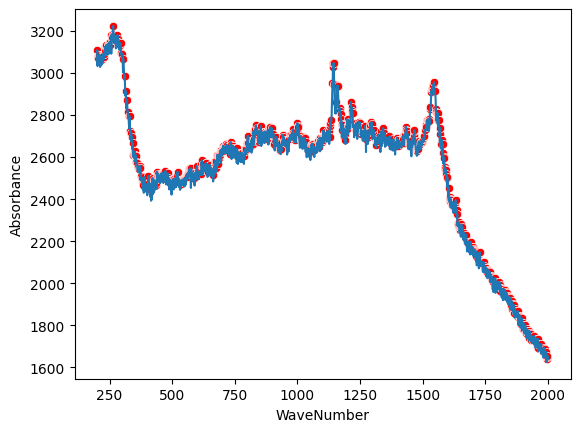

In [12]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

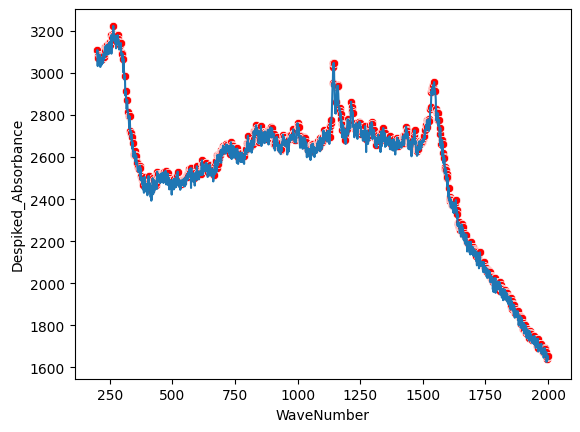

In [13]:
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[despiked_peaks], x="WaveNumber", y="Despiked_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

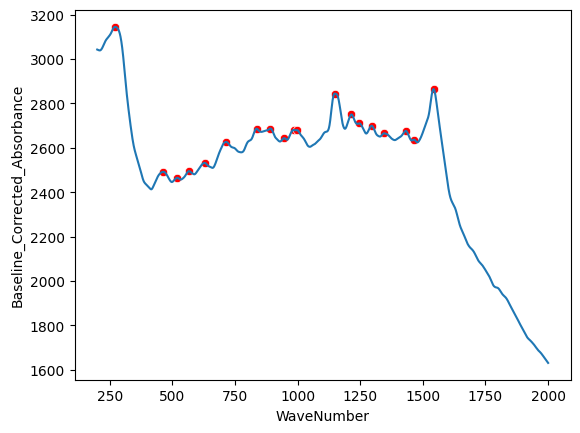

In [14]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

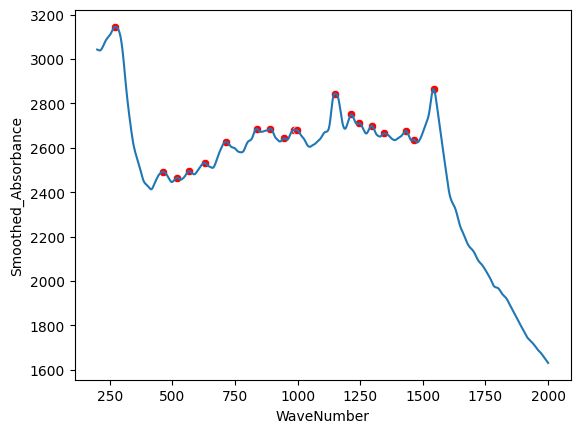

In [15]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

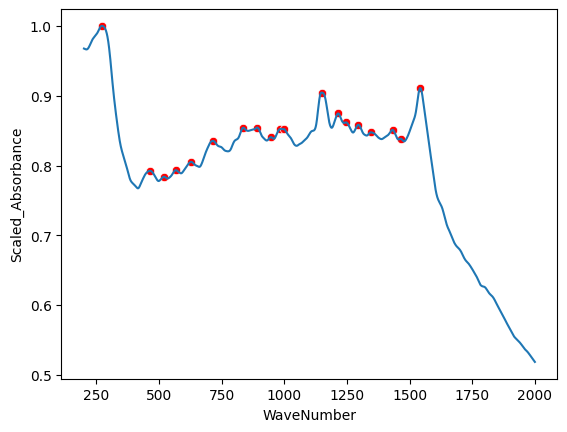

In [16]:
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[normalised_peaks], x="WaveNumber", y="Scaled_Absorbance", color="red")

The average baseline corrected spectrum of each status

<AxesSubplot: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

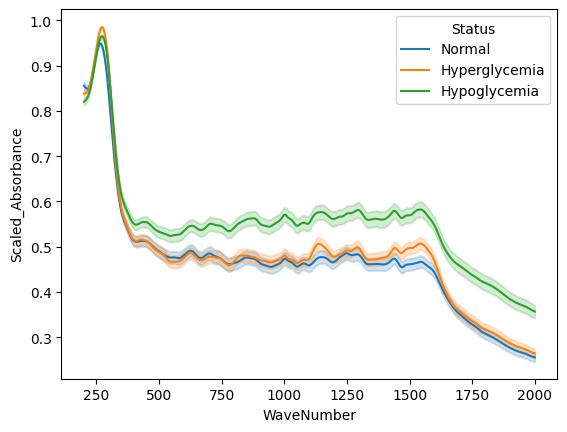

In [17]:
sns.lineplot(data=df, x='WaveNumber', y='Scaled_Absorbance', hue='Status')

#### Machine Learning

In [18]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [19]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

In [20]:
spectra_df.to_csv("../../data/scaled_and_noise_removal.csv")

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [19]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [20]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [21]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.998435,0.996880,0.995333,0.993794,0.992259,0.990735,0.989228,0.987741,0.986277,...,0.404450,0.404232,0.404023,0.403821,0.403623,0.403425,0.403231,0.403040,0.402852,Normal
201210-1-01,1.000000,0.997784,0.995571,0.993362,0.991156,0.988951,0.986752,0.984558,0.982372,0.980197,...,0.423986,0.424210,0.424442,0.424680,0.424923,0.425165,0.425411,0.425659,0.425911,Normal
201210-1-02,1.000000,0.997002,0.994016,0.991044,0.988084,0.985128,0.982189,0.979273,0.976385,0.973533,...,0.568881,0.570079,0.571272,0.572461,0.573646,0.574831,0.576013,0.577192,0.578369,Normal
201210-1-03,0.741209,0.758076,0.774771,0.791293,0.807643,0.823983,0.840069,0.855790,0.871042,0.885727,...,0.195789,0.195683,0.195578,0.195474,0.195370,0.195266,0.195161,0.195057,0.194953,Normal
201210-1-04,1.000000,0.998114,0.996231,0.994350,0.992470,0.990592,0.988716,0.986844,0.984978,0.983121,...,0.496956,0.496816,0.496688,0.496571,0.496460,0.496351,0.496247,0.496147,0.496054,Normal


##### 1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.

In [22]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [23]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [24]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.9307 +/- 0.0149
ExtraTreesClassifier Cross-Validation Accuracy: 0.9491 +/- 0.0113


#### 2. Using Peak Statistics

This uses statistical properties of the peaks in each sample to be used as additional features.

In [25]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    # peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [26]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

60378
60378
60378


/tmp/ipykernel_2151/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_2151/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [27]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
243,201210-1-00,243,366.05923,201210-1,Normal,0.691148,11.241177,0.000632
372,201210-1-00,372,454.21411,201210-1,Normal,0.653129,20.821801,0.000952
476,201210-1-00,476,525.28473,201210-1,Normal,0.637393,27.575649,0.002414
609,201210-1-00,609,616.17310,201210-1,Normal,0.673884,56.889969,0.043064
726,201210-1-00,726,696.12756,201210-1,Normal,0.672920,47.353488,0.047756


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [28]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [29]:
peak_stats = pd.merge(peak_stats, statuses, on='SpecID')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(False)

In [30]:
peak_stats.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min,Status
SpecID,,,,,,,,,,,,,,
201210-1-00,0.588035,0.067475,22,0.691148,0.411766,33.012231,30.964040,116.531105,4.445955,0.008744,0.014482,0.047756,4.113576e-06,Normal
201210-1-01,0.595307,0.065707,21,0.684668,0.424045,36.736149,36.131082,141.320235,0.770091,0.010940,0.015709,0.049438,4.814772e-07,Normal
201210-1-02,0.613284,0.065850,18,0.833390,0.523686,47.413053,41.633435,165.964809,4.544830,0.033690,0.070577,0.289205,2.398372e-05,Normal
201210-1-03,0.374926,0.200006,17,1.000000,0.261645,40.007533,23.074929,83.426549,6.324263,0.039595,0.066688,0.258791,3.578031e-05,Normal
201210-1-04,0.654181,0.074380,18,0.916542,0.534441,53.498900,58.207152,239.335118,5.374095,0.015369,0.025537,0.108191,3.050829e-05,Normal


In [31]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_stats.drop(['Status'], axis=1)
y = peak_stats['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.7465 +/- 0.0171
ExtraTreesClassifier Cross-Validation Accuracy: 0.7599 +/- 0.0156


Combine these peak statistics with the full wavelength

In [32]:
stats_and_spectrum = peak_stats.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [33]:
stats_and_spectrum.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.588035,0.067475,22,0.691148,0.411766,33.012231,30.964040,116.531105,4.445955,0.008744,...,0.404679,0.404450,0.404232,0.404023,0.403821,0.403623,0.403425,0.403231,0.403040,0.402852
201210-1-01,0.595307,0.065707,21,0.684668,0.424045,36.736149,36.131082,141.320235,0.770091,0.010940,...,0.423769,0.423986,0.424210,0.424442,0.424680,0.424923,0.425165,0.425411,0.425659,0.425911
201210-1-02,0.613284,0.065850,18,0.833390,0.523686,47.413053,41.633435,165.964809,4.544830,0.033690,...,0.567676,0.568881,0.570079,0.571272,0.572461,0.573646,0.574831,0.576013,0.577192,0.578369
201210-1-03,0.374926,0.200006,17,1.000000,0.261645,40.007533,23.074929,83.426549,6.324263,0.039595,...,0.195897,0.195789,0.195683,0.195578,0.195474,0.195370,0.195266,0.195161,0.195057,0.194953
201210-1-04,0.654181,0.074380,18,0.916542,0.534441,53.498900,58.207152,239.335118,5.374095,0.015369,...,0.497111,0.496956,0.496816,0.496688,0.496571,0.496460,0.496351,0.496247,0.496147,0.496054


In [34]:
# Splitting the dataframe into features (X) and target variable (y)
X = stats_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = stats_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.9310 +/- 0.0112
ExtraTreesClassifier Cross-Validation Accuracy: 0.9507 +/- 0.0110


#### 3. Creating a uniform Peak Featureset

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [35]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [36]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

60378
60378
60378


/tmp/ipykernel_2151/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_2151/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [37]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
243,201210-1-00,243,366.05923,201210-1,Normal,0.691148,11.241177,0.000632
372,201210-1-00,372,454.21411,201210-1,Normal,0.653129,20.821801,0.000952
476,201210-1-00,476,525.28473,201210-1,Normal,0.637393,27.575649,0.002414
609,201210-1-00,609,616.17310,201210-1,Normal,0.673884,56.889969,0.043064
726,201210-1-00,726,696.12756,201210-1,Normal,0.672920,47.353488,0.047756


Assign Peaks to bins of a fixed wavelength interval.

In [46]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_2151/2722039576.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [47]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
243,201210-1-00,243,366.05923,201210-1,Normal,0.691148,11.241177,0.000632,200-400
372,201210-1-00,372,454.21411,201210-1,Normal,0.653129,20.821801,0.000952,400-600
476,201210-1-00,476,525.28473,201210-1,Normal,0.637393,27.575649,0.002414,400-600
609,201210-1-00,609,616.17310,201210-1,Normal,0.673884,56.889969,0.043064,600-800
726,201210-1-00,726,696.12756,201210-1,Normal,0.672920,47.353488,0.047756,600-800


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [48]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

In [49]:
peak_bins.head()

,Absorbance_1000-1200,Absorbance_1200-1400,Absorbance_1400-1600,Absorbance_1600-1800,Absorbance_1800-2000,Absorbance_200-400,Absorbance_400-600,Absorbance_600-800,Absorbance_800-1000,PeakProminences_1000-1200,...,PeakWidths_1000-1200,PeakWidths_1200-1400,PeakWidths_1400-1600,PeakWidths_1600-1800,PeakWidths_1800-2000,PeakWidths_200-400,PeakWidths_400-600,PeakWidths_600-800,PeakWidths_800-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.623352,0.575864,0.560304,0.532765,0.411766,0.691148,0.653129,0.673884,0.639364,0.020781,...,64.501754,50.591548,107.67274,10.301456,4.745196,11.241177,27.575649,56.889969,116.531105,Normal
201210-1-01,0.617346,0.571806,0.568353,0.55161,0.424045,0.684668,0.662618,0.665926,0.647288,0.01261,...,50.912695,70.821010,141.320235,9.897513,38.022061,9.198319,30.708754,52.232788,114.678687,Normal
201210-1-02,0.622258,0.611892,0.626421,0.642829,0.548634,False,0.600571,0.685181,0.83339,0.01611,...,56.536449,63.781678,137.64114,165.964809,22.027491,False,39.122526,50.117829,46.47195,Normal
201210-1-03,0.352635,0.309503,0.364271,False,False,1.0,0.28491,0.333197,0.363234,0.056162,...,61.968204,35.642133,66.415216,False,False,49.116732,48.708232,53.21706,83.426549,Normal
201210-1-04,0.643906,0.658561,0.681539,0.690959,0.534441,0.916542,0.644712,0.641751,0.609801,0.013083,...,51.756093,49.545920,149.967103,239.335118,8.47468,13.08875,47.106708,55.179531,100.717433,Normal


In [50]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8775 +/- 0.0171
ExtraTreesClassifier Cross-Validation Accuracy: 0.8837 +/- 0.0176


Merge with the full spectrum.

In [51]:
bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [52]:
bins_and_spectrum.head()

,Absorbance_1000-1200,Absorbance_1200-1400,Absorbance_1400-1600,Absorbance_1600-1800,Absorbance_1800-2000,Absorbance_200-400,Absorbance_400-600,Absorbance_600-800,Absorbance_800-1000,PeakProminences_1000-1200,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.623352,0.575864,0.560304,0.532765,0.411766,0.691148,0.653129,0.673884,0.639364,0.020781,...,0.404679,0.404450,0.404232,0.404023,0.403821,0.403623,0.403425,0.403231,0.403040,0.402852
201210-1-01,0.617346,0.571806,0.568353,0.55161,0.424045,0.684668,0.662618,0.665926,0.647288,0.01261,...,0.423769,0.423986,0.424210,0.424442,0.424680,0.424923,0.425165,0.425411,0.425659,0.425911
201210-1-02,0.622258,0.611892,0.626421,0.642829,0.548634,False,0.600571,0.685181,0.83339,0.01611,...,0.567676,0.568881,0.570079,0.571272,0.572461,0.573646,0.574831,0.576013,0.577192,0.578369
201210-1-03,0.352635,0.309503,0.364271,False,False,1.0,0.28491,0.333197,0.363234,0.056162,...,0.195897,0.195789,0.195683,0.195578,0.195474,0.195370,0.195266,0.195161,0.195057,0.194953
201210-1-04,0.643906,0.658561,0.681539,0.690959,0.534441,0.916542,0.644712,0.641751,0.609801,0.013083,...,0.497111,0.496956,0.496816,0.496688,0.496571,0.496460,0.496351,0.496247,0.496147,0.496054


In [53]:
# Splitting the dataframe into features (X) and target variable (y)
X = bins_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.9297 +/- 0.0107
ExtraTreesClassifier Cross-Validation Accuracy: 0.9498 +/- 0.0093


In [54]:
# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Training the classifier on the entire dataset
    clf.fit(X, y)
    
    # Displaying the cross-validation results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    
    # Displaying the top 10 most important features
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
    top_features = X.columns[indices]
    print(f'Top 10 Features: {top_features}')

RandomForestClassifier Cross-Validation Accuracy: 0.9297 +/- 0.0107
Top 10 Features: Index(['275.85422', '282.00455', '275.17084', '268.33713', '281.3212',
       '277.22095', '271.07062', '282.68793', '285.42142', '279.27106'],
      dtype='object')
ExtraTreesClassifier Cross-Validation Accuracy: 0.9498 +/- 0.0093
Top 10 Features: Index(['294.98862', '281.3212', '276.5376', '272.43735', '293.62186',
       '282.00455', '290.20502', '291.57175', '299.77222', '284.73804'],
      dtype='object')


Try the raw spectrum with the baseline corrected peaks.

In [55]:
spectra_df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

#Create a field for each wavelength.
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None
#Add the statuses back.
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [56]:
raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [57]:
# Splitting the dataframe into features (X) and target variable (y)
X = raw_spec_baseline_bins.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8762 +/- 0.0157
ExtraTreesClassifier Cross-Validation Accuracy: 0.8903 +/- 0.0188


In [58]:
raw_spec_baseline_bins.to_csv("../../data/raw_spec_and_max_bins.csv")